# DINEOF

In [1]:
import autoroot
import numpyro
import numpyro.distributions as dist
from jax import config
config.update("jax_enable_x64", True)
import jax
import jax.numpy as jnp
import numpy as np
import jax.random as jr
import xarray_einstats
from sklearn.decomposition import PCA
from oi_toolz._src.models.pca import DINEOF
from sklearn.preprocessing import MinMaxScaler
import xarray as xr
import pandas as pd
import einx
import cola
from tqdm.auto import trange, tqdm

key = jr.key(123)

import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.75)


%matplotlib inline

%load_ext autoreload
%autoreload 2

## Data

In [31]:
ds = xr.tutorial.open_dataset("air_temperature")
ds

<xarray.Dataset>
Dimensions:  (lat: 25, time: 2920, lon: 53)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 ...
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

In [32]:
def calculate_dt(ds: xr.Dataset) -> xr.Dataset:
    return ds.time.diff("time")

In [34]:
calculate_dt(ds).values

array([21600000000000, 21600000000000, 21600000000000, ...,
       21600000000000, 21600000000000, 21600000000000],
      dtype='timedelta64[ns]')

In [3]:
# change units
# ds = ds.sel(time=slice("2013-01-01", "2013-02-01"))
ds["air"] = ds.air - 273.15

In [4]:
sigma = 0.01
rng = np.random.RandomState(123)
ds["air_noisy"] = ds["air"].copy() + sigma ** 2 * rng.normal(*ds["air"].shape[:-1])

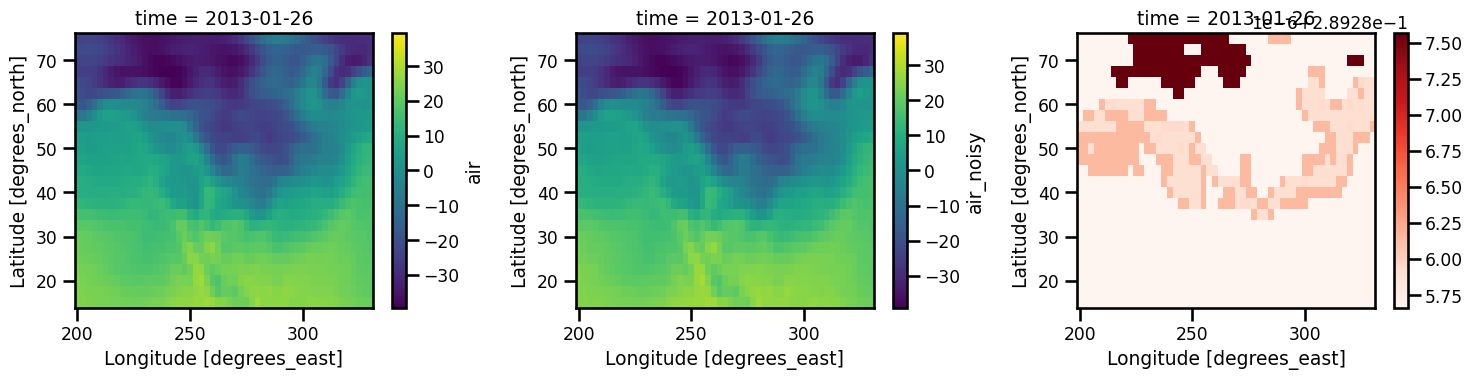

In [5]:
fig, ax = plt.subplots(ncols=3, figsize=(15,4))

itime = 100

ds.air.isel(time=itime).plot.pcolormesh(x="lon", ax=ax[0], cmap="viridis")
ds.air_noisy.isel(time=itime).plot.pcolormesh(x="lon",ax=ax[1], cmap="viridis")
np.abs(ds.air - ds.air_noisy).isel(time=itime).plot.pcolormesh(x="lon",ax=ax[2],cmap="Reds")

plt.tight_layout()
plt.show()

### Rearrange Data

In [6]:
# tranpose
ds = ds.transpose("time", "lon", "lat")
data = ds.air.stack(spatial=["lon", "lat"])
data = data.transpose("spatial", "time")

In [7]:
n_space = data.spatial.shape[0]
n_time = data.time.shape[0]

## Model

In [8]:
import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS
from jaxtyping import Float, Array

In [9]:
n_space, n_time

(1325, 2920)

In [10]:
dim_latent = 500

def model(obs: Float[Array, "N Dy"], obs_mask=None):
    N, Dy = obs.shape
    # print(N, Dy)
    # calculate alpha, prior for weights
    rate: Float[Array, "Dz"] = jnp.ones(shape=(dim_latent,))
    alpha_w: Float[Array, "Dz"] = numpyro.sample("alpha", dist.Exponential(rate=rate).to_event(1))
    rate: Float[Array, "Dz"] = jnp.ones(shape=(dim_latent,))
    loc = jnp.zeros((N,))
    scale = jnp.ones((N,))
    mu: Float[Array, "N"] = numpyro.sample("mu", dist.Normal(loc, scale).to_event(1))
    # calculate W
    loc: Float[Array, "Dz"] = jnp.zeros(shape=(n_time, dim_latent))
    # print(alpha.shape, dim_latent)
    scale: Float[Array, "Dy Dy"] = einx.rearrange("Dz -> Dy Dz", alpha_w, Dy=n_time)
    W: Float[Array, "Dx Dz"] = numpyro.sample("W", dist.Normal(loc, scale).to_event(1))
    # scale
    sigma: Float[Array, ""] = numpyro.sample("sigma", dist.HalfCauchy(scale=1))
    # TODO: add bias...
    # different batches
    with numpyro.plate("samples", N):
        # latent variable
        loc = jnp.zeros(shape=(dim_latent,))
        scale = jnp.ones(shape=(dim_latent,))
        
        z: Float[Array, "Dz"] = numpyro.sample("z", dist.Normal(loc,scale).to_event(1))
        # calculate mean
        loc: Float[Array, "N Dy"] = einx.dot("Dy Dz, N Dz -> N Dy", W, z) 
        loc: Float[Array, "N Dy"] = einx.add("N Dy, N -> N Dy", loc, mu)
        
        # calculate scale
        # print(loc.shape)
        scale: Float[Array, "Dy"] = sigma * jnp.ones(shape=(Dy,))
        # print("loc:", loc.shape)
        # print("scale:", scale.shape)
        # print("obs:", obs.shape)
        d = dist.Normal(loc=loc, scale=scale).to_event(1)
        # if obs_mask:
        #     d = d.mask(obs_mask)
        
        y = numpyro.sample("y", d, obs=obs, obs_mask=obs_mask)
        

In [11]:
from numpyro.infer.autoguide import AutoDelta
from numpyro.infer import Predictive, SVI, Trace_ELBO
import jax.random as jrandom

In [13]:
# initialize MAP guide
map_guide = AutoDelta(model)

# initialize svi inference
loss = Trace_ELBO()
optimizer = numpyro.optim.Adam(step_size=0.01)
svi = SVI(model=model, guide=map_guide, optim=optimizer, loss=loss)

num_samples: int = 1
num_steps: int = 10_000
rng_key= jrandom.PRNGKey(123)
obs_mask = None #jnp.ones_like(data.values).astype(bool)
svi_result = svi.run(rng_key=rng_key, num_steps=num_steps, obs=data.values, obs_mask=obs_mask)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [09:16<00:00, 17.97it/s, init loss: 827929149.1002, avg. loss [9501-10000]: -4427046.0603]


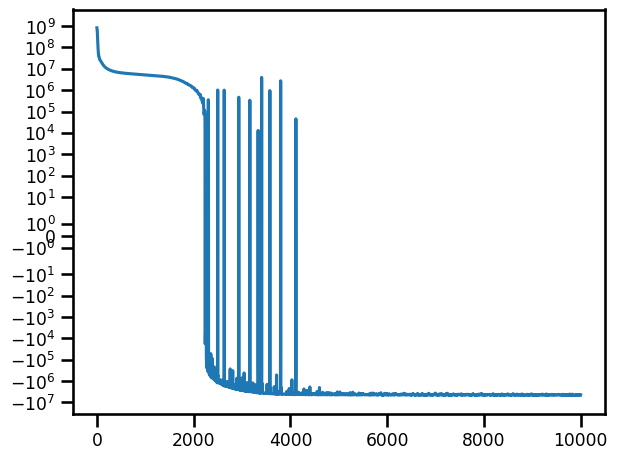

In [27]:
fig, ax = plt.subplots()
ax.plot(svi_result.losses)
ax.set(yscale="symlog")
plt.tight_layout()
plt.show()

In [15]:
# svi_result.params

In [16]:
from numpyro.infer import Predictive

In [17]:
params = svi_result.params
# samples = guide.get_posterior(params)
num_samples = 1
predictive = Predictive(map_guide, params=params, num_samples=num_samples)
posterior_samples = predictive(jrandom.PRNGKey(0))
variables = list(posterior_samples.keys())
posterior_samples["W"].shape, posterior_samples["alpha"].shape, posterior_samples["z"].shape

((1, 2920, 500), (1, 500), (1, 1325, 500))

In [19]:
# posterior_samples["mu"].shape, X_recon.shape

In [20]:
X_recon = einx.dot("B Dt Dz, B Ds Dz -> Ds Dt", posterior_samples["W"], posterior_samples["z"])
X_recon = einx.add("Ds Dt, Ds -> Ds Dt", X_recon, posterior_samples["mu"].squeeze())
X_recon.shape

(1325, 2920)

In [21]:
data["mean_field"] = (("spatial",), posterior_samples["mu"].squeeze())

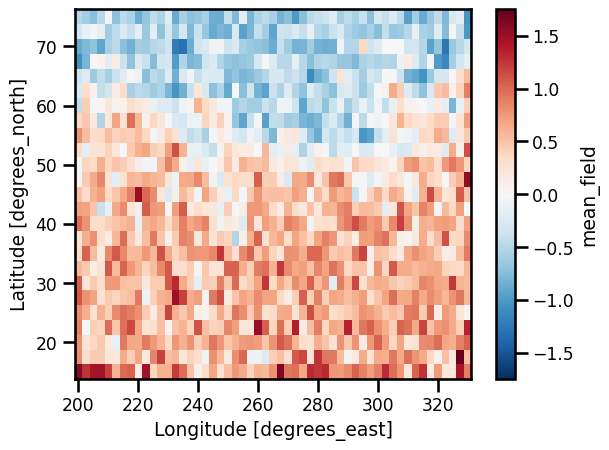

In [22]:
data.mean_field.unstack().plot.pcolormesh(x="lon")

In [23]:
data["recon"] = (("spatial", "time"), X_recon)

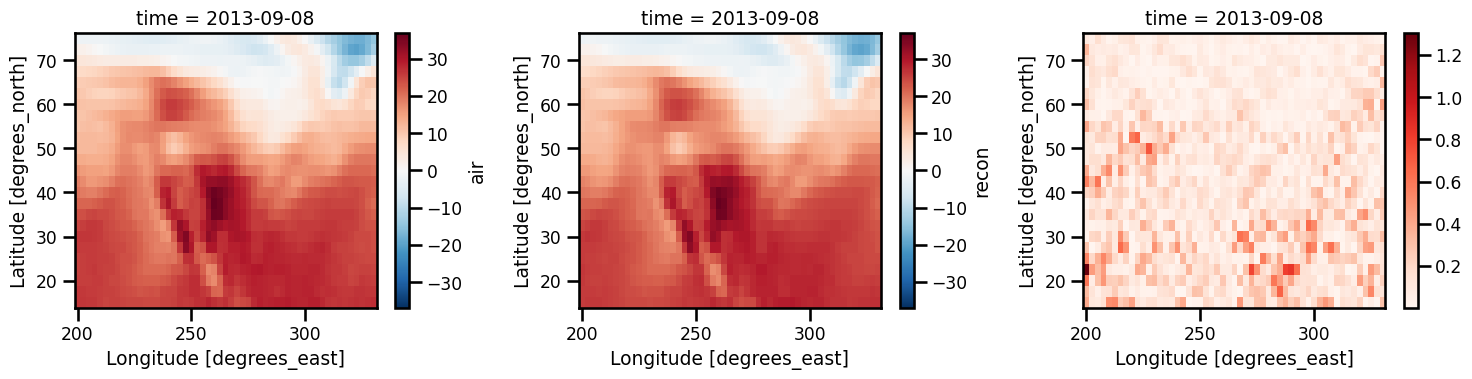

In [28]:
fig, ax = plt.subplots(ncols=3, figsize=(15,4))

itime = 1000

data.unstack().isel(time=itime).plot.pcolormesh(x="lon", ax=ax[0])
data.recon.unstack().isel(time=itime).plot.pcolormesh(x="lon",ax=ax[1])
np.abs(data - data.recon).unstack().isel(time=itime).plot.pcolormesh(x="lon",ax=ax[2],cmap="Reds")

plt.tight_layout()
plt.show()

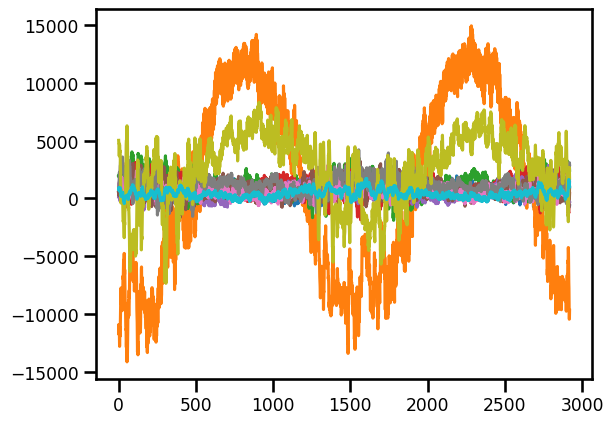

In [176]:
fig, ax = plt.subplots()

ax.plot()

In [8]:
ds

<xarray.Dataset>
Dimensions:    (time: 2920, spatial: 1325)
Coordinates:
  * time       (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
  * spatial    (spatial) object MultiIndex
  * lon        (spatial) float32 200.0 200.0 200.0 200.0 ... 330.0 330.0 330.0
  * lat        (spatial) float32 75.0 72.5 70.0 67.5 ... 22.5 20.0 17.5 15.0
Data variables:
    air        (time, spatial) float32 -31.95 -29.35 -23.15 ... 22.04 22.54
    air_noisy  (time, spatial) float32 -31.66 -29.06 -22.86 ... 22.33 22.83
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...